# E3 Prelab Q1-2 Part 1

In Q1 you are asked to compare the titration data obtained from E2 to the model of a titration that you developed in the E2 prelab. You are then asked to modify some parameters in the model to best fit the experimental data. 

The model is an expression for the number of Ce(IV) added as  function of potential. A comparison will require you to convert steps of the sringe pump to the number of Ce(IV) added. This first part shows an example of a similar conversion to grams of the Ce(IV)-containing solution added based off the 'Fine Titration Data.txt' uploaded to canvas. 

## Import Packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('JGW')
import pandas as pd

# Import titration data 

Import titration data into a pandas dataframe. For the example dataset, the delimiters are commas and the first 4 rows contains details of the calibration that you will need to convert steps to number of Ce(IV) added.  We skip those rows in the first step. The format of your titration data may differ.  

In [2]:
data_path = r"C:\Users\jgage\OneDrive - Stanford\2021\CHEM 274\Labs\E3\Fine Titration Data.txt"
titration_data = pd.read_csv(data_path, skiprows = 4, sep = ',')

# Read calibration data

Here we simply want to see the pump calibration values. In the example file the calibration data are in the first four rows of the file. Your own calibration data might be located elsewhere e.g. in your lab notebook. 

In [3]:
# read first 4 lines of titration data which contains the calibration info
calibration_data = pd.read_csv(data_path, nrows = 4, header = None, sep = ':')
# create dictionary containing calibration information
calibration_dict = dict(zip(calibration_data[0], calibration_data[1]))
# calibration_dict

# Convert steps to grams of solution added

Use the calibration data to convert the number of steps of Ce(IV) added in the titration to grams of the Ce(IV)-containing solution added. In the example file, 1 step correspoonds to 1.355/6000 grams of Ce(IV) solution 

In [4]:
number_steps_in_calibration = 6000
mass_of_calibration_in_g = 1.355

# convert steps to grams of solution, then moles of Ce(IV)
titration_data['step in g sol'] = (titration_data['step'] / number_steps_in_calibration) * mass_of_calibration_in_g
titration_data['step in mol Ce(IV)'] = titration_data['step in g sol'] * (0.990 / 20.030) / 548.22
# titration_data

## Plot data

After you finish the conversion of steps to number of Ce(IV) added, adjust the code below to plot your converted titration data.

Text(0, 0.5, 'Potential / V')

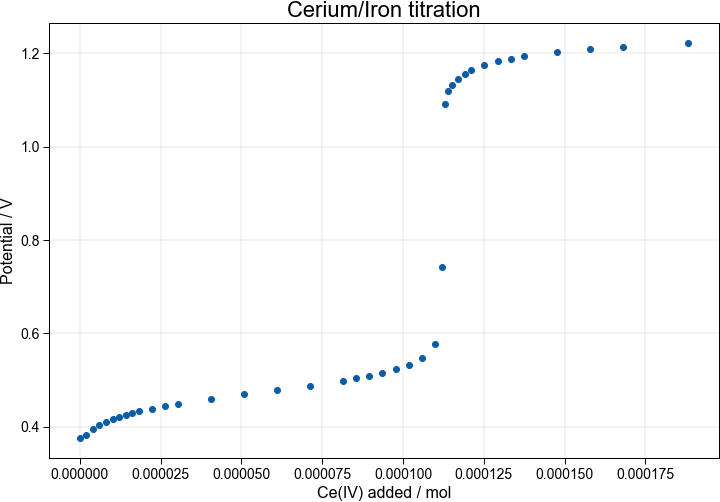

In [5]:
# plot data
fig, ax = plt.subplots()
ax.errorbar(x = titration_data['step in mol Ce(IV)'] , y = titration_data['mean potential'], 
             yerr = titration_data['std dev'], fmt='o', ecolor='k', capsize=2)

ax.set_title('Cerium/Iron titration')
ax.set_xlabel('Ce(IV) added / mol')
ax.set_ylabel('Potential / V')

# # E3 Prelab Q1-2 Part 2

In the second part of Q1, you will overlay the titration data with the derived titration curve (model) and estimate the redox potentials required for the model to match the experimental data. This is a visual way to estimate the parameters in the model. You are welcome to go further and use nonlinear fitting routines to further refine the parameters, but you do not need to do so. 

The example below shows how you can visually model a dataset. Here the data is compared to the function y = a sin(bx + c). Change a, b and c to visually match the model to the synthetic dataset. 

In [6]:
def E_predict(n_Ce4, n_Fe2, E0_Fe, E0_Ce):
    '''
    Returns E_cell based on the manually derived solution
    '''
    R, T, F = 8.314, 298, 96485
    a = F/(R*T)
    argument = ((np.exp(E0_Ce * a)/2)*(n_Ce4/n_Fe2 -1 + np.sqrt((1 - n_Ce4/n_Fe2)**2 + 4*np.exp((E0_Fe - E0_Ce)*a))))
    return np.log(argument) / a

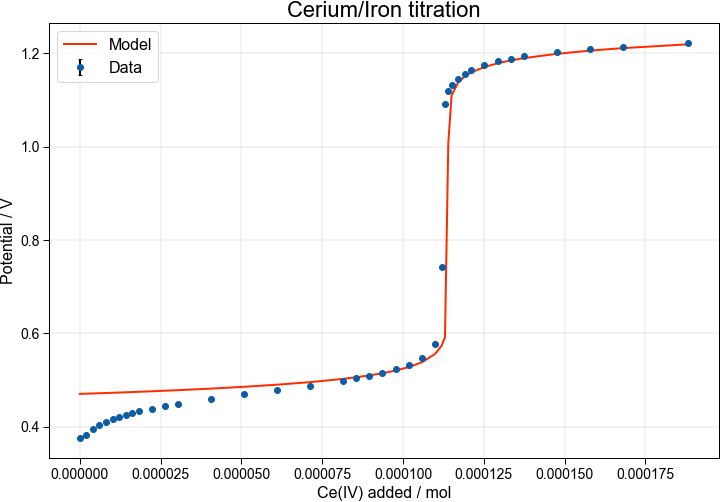

In [7]:
# Data 
x_data = titration_data['step in mol Ce(IV)']
y_data = titration_data['mean potential']

# Guess some values of n_Fe2, E0_Fe, E0_Ce, 
guess_n_Fe2 = 1.140 * 10**-4
guess_E0_Fe = 0.47
guess_E0_Ce = 1.23
guesses = [guess_n_Fe2, guess_E0_Fe, guess_E0_Ce]

y_model = []
for step in range(len(x_data)):
    n_Ce4 = x_data[step]
    y_model.append(E_predict(n_Ce4, *guesses))
    
# Plot data overlaid with model
fig, ax = plt.subplots()
ax.errorbar(x = titration_data['step in mol Ce(IV)'] , y = titration_data['mean potential'], 
             yerr = titration_data['std dev'], fmt='o', ecolor='k', capsize=2, label='Data')
ax.set_title('Cerium/Iron titration')
ax.set_xlabel('Ce(IV) added / mol')
ax.set_ylabel('Potential / V')
ax.plot(x_data, y_model, label='Model')
ax.legend()


plt.show()

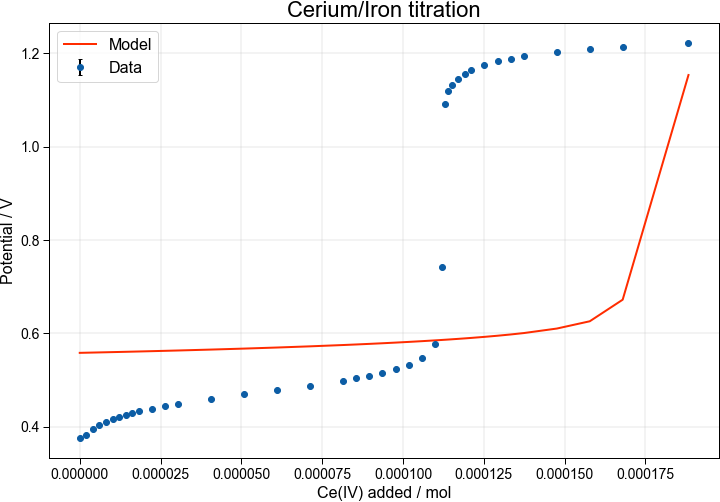

In [8]:
# Optimize using guesses
from scipy.optimize import curve_fit

guess_n_Fe2 = 1.70 * 10**-4
guess_E0_Fe = 0.48
guess_E0_Ce = 1.20
guesses = [guess_n_Fe2, guess_E0_Fe, guess_E0_Ce]

iterations = 10
for i in range(iterations):
    y_model2, _ = curve_fit(E_predict, x_data, y_data, p0=guesses)
    guesses = y_model2

fig, ax = plt.subplots()
ax.errorbar(x = titration_data['step in mol Ce(IV)'] , y = titration_data['mean potential'], 
             yerr = titration_data['std dev'], fmt='o', ecolor='k', capsize=2, label='Data')
ax.set_title('Cerium/Iron titration')
ax.set_xlabel('Ce(IV) added / mol')
ax.set_ylabel('Potential / V')
ax.plot(x_data, E_predict(x_data, *y_model2), label='Model')
ax.legend()

plt.show()

In [9]:
print(y_model2)

[1.69989237e-04 5.57926647e-01 1.21039553e+00]


Scipy's curve_fit, a non-linear routine, is not particularly good at this unless given fantastic guesses. Perhaps this is due to the functional form of E_predict.

In [10]:
# Now adding a constant to the model
def E_predict_plus_c(n_Ce4, n_Fe2, E0_Fe, E0_Ce, c):
    '''
    Returns E_cell
    '''
    R, T, F = 8.314, 298, 96485
    a = F/(R*T)
    disc = (np.exp(2*E0_Ce*a))*(1 - c - n_Ce4/n_Fe2)**2 + 4*(n_Ce4/n_Fe2)*np.exp((E0_Fe + E0_Ce)*a)
    argument = (1/2) * ((-np.exp(E0_Ce * a)*(1 - n_Ce4/n_Fe2 -c) + np.sqrt(disc)))
    return np.log(argument) / a

C:\Users\jgage\AppData\Local\Temp/ipykernel_20708/259391733.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(argument) / a


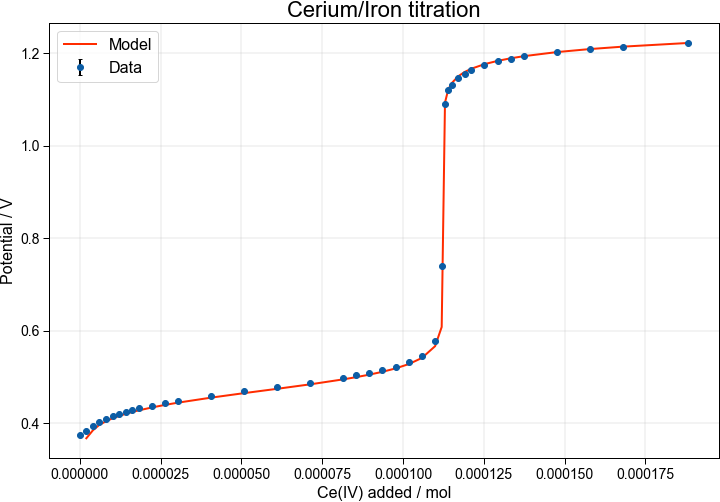

In [16]:
# Guess some values of n_Fe2, E0_Fe, E0_Ce, and c
guess_n_Fe2 = 2.25 * 10**-4
guess_E0_Fe = 0.47
guess_E0_Ce = 1.25
guess_c = 0.5
guesses = [guess_n_Fe2, guess_E0_Fe, guess_E0_Ce, guess_c]

y_model3 = []
for step in range(len(x_data)):
    n_Ce4 = x_data[step]
    y_model3.append(E_predict_plus_c(n_Ce4, *guesses))

# Plot data overlaid with model
fig, ax = plt.subplots()
ax.errorbar(x = titration_data['step in mol Ce(IV)'] , y = titration_data['mean potential'],
            yerr = titration_data['std dev'], fmt='o', ecolor='k', capsize=2, label='Data')
ax.set_title('Cerium/Iron titration')
ax.set_xlabel('Ce(IV) added / mol')
ax.set_ylabel('Potential / V')
ax.plot(x_data, y_model3, label='Model')
ax.legend()


plt.show()

In [19]:
# Optimize using guesses
from scipy.optimize import curve_fit

guess_n_Fe2 = 2.25 * 10**-4
guess_E0_Fe = 0.47
guess_E0_Ce = 1.25
guess_c = 0.5
guesses = [guess_n_Fe2, guess_E0_Fe, guess_E0_Ce, guess_c]

iterations = 10
for i in range(iterations):
    y_model4, _ = curve_fit(E_predict_plus_c, x_data, y_data, p0=guesses)
    guesses = y_model4

fig, ax = plt.subplots()
ax.errorbar(x = titration_data['step in mol Ce(IV)'] , y = titration_data['mean potential'],
            yerr = titration_data['std dev'], fmt='o', ecolor='k', capsize=2, label='Data')
ax.set_title('Cerium/Iron titration')
ax.set_xlabel('Ce(IV) added / mol')
ax.set_ylabel('Potential / V')
ax.plot(x_data, E_predict_plus_c(x_data, *y_model4), label='Model')
ax.legend()

plt.show()

C:\Users\jgage\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.